In [1]:
from glob import glob
import pandas as pd
import seaborn as sns
import os
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from pyprojroot.here import here
import anndata as ad
from sklearn.metrics import f1_score, balanced_accuracy_score
from itertools import product
import sys

from tqdm.auto import tqdm

sys.path.insert(1, str(here('bin')))
from customPalette import shap_cell_types as CELL_TYPES

In [2]:
def TO_REMOVE_return_dfs(n_genes):
    all_dfs = [pd.read_csv(fpath, index_col=0) for fpath in glob(str(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/xgboost_TopN_genes/results_{n_genes}/metrics/*')))]
    all_dfs = pd.concat(all_dfs)
    all_dfs = all_dfs.assign(setting=[s if s in ['shap', 'all', 'shap_studyID','shap_disease_NOstudy','shap_studyID_NOdisease'] else 'rand' for s in all_dfs.gene_set_seed])
    data = all_dfs.groupby(['gene_set_seed', 'cell_type']).agg({'BAS':'mean', 'WF1':'mean','setting':'first'})
    BAS_ms = data.reset_index().groupby(['cell_type', 'setting']).BAS.agg(['mean','std']).fillna(0)
    WF1_ms = data.reset_index().groupby(['cell_type', 'setting']).WF1.agg(['mean','std']).fillna(0)
    all_ms = BAS_ms.merge(WF1_ms, right_index=True, left_index=True, suffixes=('_BAS', '_WF1')).reset_index()
    
    return data, all_ms

In [10]:
def return_dfs(n_genes):
    _dfs = []
    for _cell_type, _setting in tqdm(list(product(CELL_TYPES, ['shap', 'all', 'shap_studyID_samesize','shap_disease_NOstudy_samesize','shap_studyID_NOdisease_samesize'] + list(range(20))))):
        _dfs.append(_aux_return_dfs(n_genes, _cell_type, _setting))
    _dfs = pd.concat(_dfs)
    group_columns = ['gene_set_seed', 'cell_type', 'setting']
    results = []
    for keys, group in _dfs.groupby(group_columns):
        
        wf1 = f1_score(group['y_true_code'], group['y_pred'], average='weighted')
        bas = balanced_accuracy_score(group['y_true_code'], group['y_pred'])
    
        # Combine keys into dict
        result_row = dict(zip(group_columns, keys))
        result_row.update({'WF1': wf1, 'BAS': bas})
        
        results.append(result_row)
    data = pd.DataFrame(results)
    
    BAS_ms = data.reset_index().groupby(['cell_type', 'setting']).BAS.agg(['mean','std']).fillna(0)
    WF1_ms = data.reset_index().groupby(['cell_type', 'setting']).WF1.agg(['mean','std']).fillna(0)
    all_ms = BAS_ms.merge(WF1_ms, right_index=True, left_index=True, suffixes=('_BAS', '_WF1')).reset_index()
    
    return data, all_ms

def _aux_return_dfs(n_genes, cell_type, setting):
    dfs = [pd.read_csv(fpath, index_col=0) for fpath in glob(str(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/xgboost_TopN_genes/results_{n_genes}/predictions/{cell_type}_{setting}_[0-5]*')))]
    if len(dfs) == 0:
        return None
    assert len(dfs) == 5
    dfs = pd.concat(dfs)
    dfs = dfs.assign(
       gene_set_seed=setting if isinstance(setting, int) else 0,
       setting='rand' if isinstance(setting, int) else setting,
       cell_type=cell_type)
    return dfs

In [7]:
_check = [pd.read_csv(fpath, index_col=0) for fpath in glob(str(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/xgboost_TopN_genes/results_20/predictions/B_shap_[0-5]*')))]
_check = pd.concat(_check)
f1_score(_check.y_true_code, _check.y_pred, average='weighted')

0.6763291436974234

In [11]:
data_5, all_ms_5 = return_dfs(5)
data_10, all_ms_10 = return_dfs(10)
data_20, all_ms_20 = return_dfs(20)

  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

In [9]:
data_5

,gene_set_seed,cell_type,setting,WF1,BAS
0,0,B,all,0.813513,0.701973
1,0,B,rand,0.631157,0.451494
2,0,B,shap,0.627771,0.457602
3,0,B,shap_disease_NOstudy_samesize,0.627630,0.432449
4,0,B,shap_studyID_NOdisease_samesize,0.628958,0.421841
...,...,...,...,...,...
270,19,T_CD4_NonNaive,rand,0.669842,0.377270
271,19,T_CD8_Naive,rand,0.637844,0.341214
272,19,T_CD8_NonNaive,rand,0.663005,0.420922
273,19,UTC,rand,0.613472,0.342101


In [10]:
data_5.setting.drop_duplicates()

0                                all
1                               rand
2                               shap
3      shap_disease_NOstudy_samesize
4    shap_studyID_NOdisease_samesize
5              shap_studyID_samesize
Name: setting, dtype: object

In [11]:
data_20

,gene_set_seed,cell_type,setting,WF1,BAS
0,0,B,rand,0.723033,0.545839
1,0,B,shap,0.676329,0.558070
2,0,B,shap_disease_NOstudy_samesize,0.745994,0.580983
3,0,B,shap_studyID_NOdisease_samesize,0.712354,0.523525
4,0,B,shap_studyID_samesize,0.772683,0.639050
...,...,...,...,...,...
259,19,T_CD4_NonNaive,rand,0.754181,0.529229
260,19,T_CD8_Naive,rand,0.748840,0.553973
261,19,T_CD8_NonNaive,rand,0.739125,0.496207
262,19,UTC,rand,0.692692,0.418509


In [12]:
all_ms_20

,cell_type,setting,mean_BAS,std_BAS,mean_WF1,std_WF1
0,B,rand,0.533139,0.026666,0.711211,0.021097
1,B,shap,0.558070,0.000000,0.676329,0.000000
2,B,shap_disease_NOstudy_samesize,0.580983,0.000000,0.745994,0.000000
3,B,shap_studyID_NOdisease_samesize,0.523525,0.000000,0.712354,0.000000
4,B,shap_studyID_samesize,0.639050,0.000000,0.772683,0.000000
5,DC,rand,0.516953,0.027949,0.794166,0.016768
6,DC,shap,0.486260,0.000000,0.705486,0.000000
7,DC,shap_disease_NOstudy_samesize,0.580223,0.000000,0.828923,0.000000
8,DC,shap_studyID_NOdisease_samesize,0.554261,0.000000,0.806735,0.000000
9,DC,shap_studyID_samesize,0.633881,0.000000,0.828807,0.000000


In [12]:
from sklearn.metrics import f1_score
from itertools import product
from tqdm.auto import tqdm

def f1_score_external_shap(
    cell_type = 'Mono',
    shap_type = 'shap_studyID',
    n_genes = 20,
    disease_list =  ['RA', 'COVID', 'HIV', 'cirrhosis', 'CD', 'healthy', 'SLE', 'sepsis']
):
    _n_genes = 5 if shap_type == 'all' else n_genes
    
    split_merge = []
    for test_idx in range(5):
        try:
            fpath = str(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/xgboost_TopN_genes/results_{_n_genes}/predictions/{cell_type}_{shap_type}_{test_idx}_pred_test.zip'))
            split_merge.append(pd.read_csv(fpath, index_col=0))
        except FileNotFoundError:
            print(cell_type, shap_type, test_idx, n_genes)
            continue

    split_merge = pd.concat(split_merge)
    map_code_label = split_merge[['y_true','y_true_code']].drop_duplicates().sort_values('y_true_code').set_index('y_true_code').to_dict()['y_true']
    split_merge = split_merge.replace(map_code_label)
    disease_list = list(map_code_label.values())
    
    new_df = dict(disease=disease_list)
    new_df['f1_score'] = f1_score(y_true=split_merge.y_true, y_pred=split_merge.y_pred, average=None, labels=disease_list)
    new_df['cell_type'] = cell_type
    new_df['n_genes'] = n_genes
    new_df['shap_type'] = 'random' if type(shap_type) == int else shap_type
    new_df['seed'] = shap_type if type(shap_type) == int else 0
    return pd.DataFrame.from_dict(new_df)

results = []
for cell_type, shap_type, n_genes in tqdm(list(product(CELL_TYPES, ['all','shap','shap_studyID_samesize','shap_disease_NOstudy_samesize','shap_studyID_NOdisease_samesize'] + list(range(20)), [5, 10, 20]))):
    results.append(f1_score_external_shap(cell_type=cell_type, shap_type=shap_type, n_genes=n_genes))

  0%|          | 0/825 [00:00<?, ?it/s]

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'CD'),
  Text(1, 0, 'COVID'),
  Text(2, 0, 'HIV'),
  Text(3, 0, 'RA'),
  Text(4, 0, 'SLE'),
  Text(5, 0, 'cirrhosis'),
  Text(6, 0, 'healthy'),
  Text(7, 0, 'sepsis')])

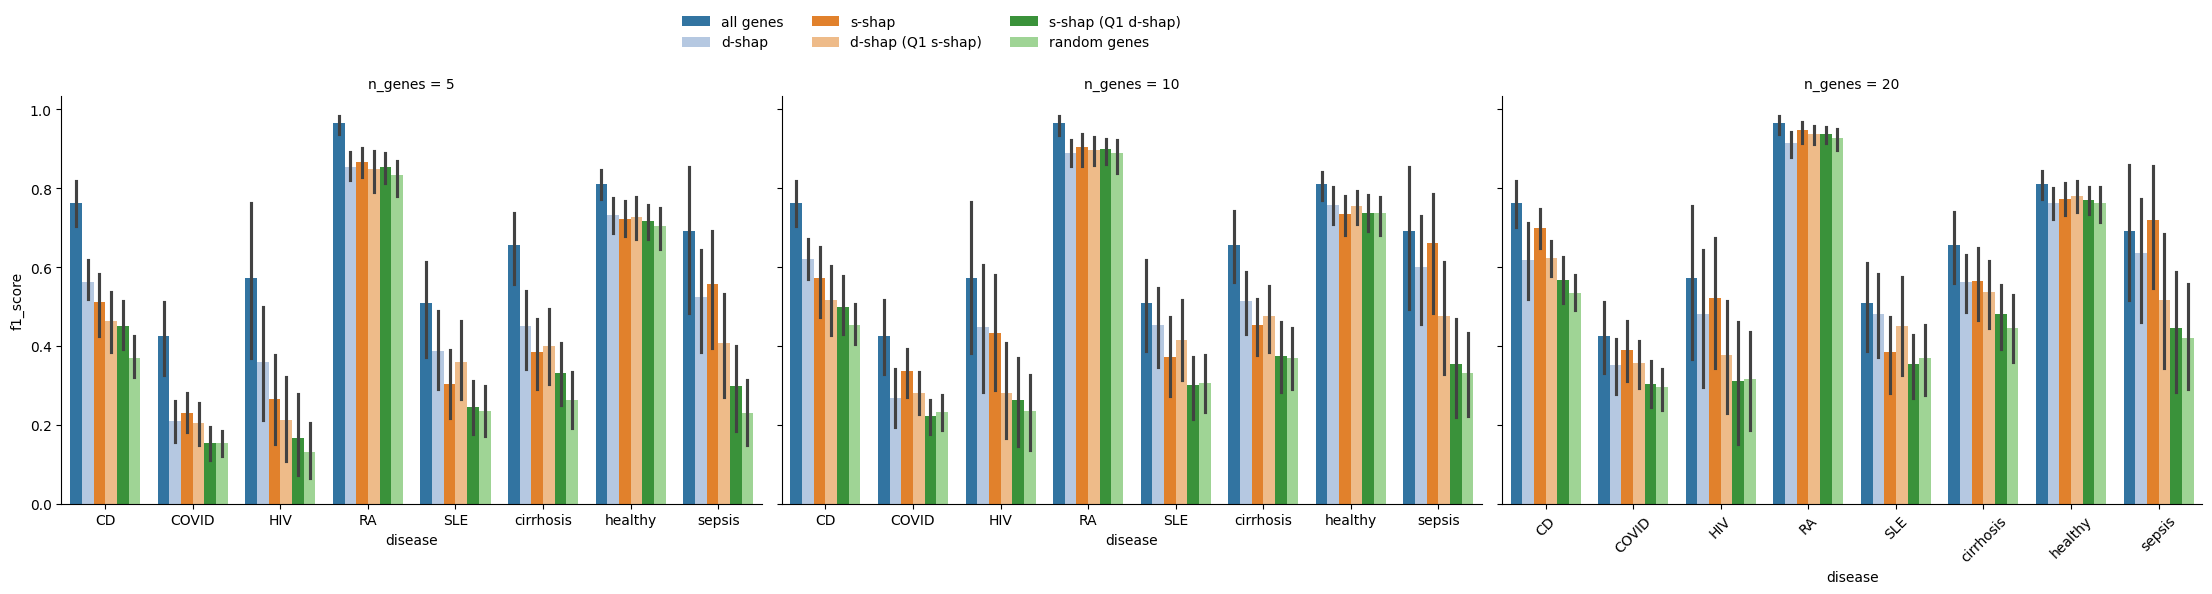

In [16]:
import seaborn as sns
from statannotations.Annotator import Annotator
from itertools import combinations

_plot_data=pd.concat(results).groupby(['n_genes', 'shap_type', 'disease', 'cell_type']).agg(dict(f1_score='mean')).reset_index()

labelDict = {'all':'all genes', 'shap':'d-shap', 'shap_studyID_samesize':'s-shap',
             'shap_disease_NOstudy_samesize':'d-shap (Q1 s-shap)', 
             'shap_studyID_NOdisease_samesize':'s-shap (Q1 d-shap)',
             'random':'random genes',}

_plot_data['shap_type'] = _plot_data['shap_type'].replace(labelDict)

cat_type = pd.api.types.CategoricalDtype(categories=labelDict.values(), ordered=True)
_plot_data.shap_type = _plot_data.shap_type.astype(cat_type)

g = sns.FacetGrid(_plot_data, col="n_genes", height=5, aspect=1.5)

g.map_dataframe(sns.barplot, x="disease", y="f1_score", hue="shap_type", palette='tab20', hue_order=labelDict.values())
g.add_legend(loc="lower left",bbox_to_anchor=(0.25, 1), ncol=3, title=None, frameon=False)
plt.xticks(rotation=45)
#plt.savefig('figures/gene_subsets_barplot.svg', bbox_inches='tight')

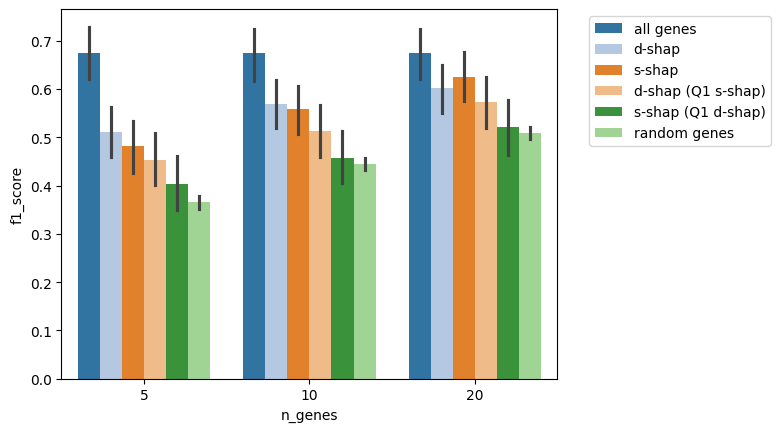

In [28]:
_d = pd.concat(results)
_d['shap_type'] = _d['shap_type'].replace(labelDict)
cat_type = pd.api.types.CategoricalDtype(categories=labelDict.values(), ordered=True)
_d.shap_type = _d.shap_type.astype(cat_type)
sns.barplot(x='n_genes', y='f1_score', hue='shap_type', data=_d, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [14]:
celltype_renamimg = {
    'B': 'B',
    'Plasma': 'Plasma',
    'pDC': 'pDC',
    'DC': 'DC',
    'Mono': 'Mono',
    'T_CD4_Naive': 'CD4 Naive',
    'T_CD4_NonNaive': 'CD4 Non-Naive',
    'T_CD8_Naive': 'CD8 Naive',
    'T_CD8_NonNaive': 'CD8 Non-Naive',
    'UTC': 'UTC',
    'ILC': 'ILC',
}

In [15]:
n_genes_ls = []
for cell_type in celltype_renamimg.keys():
    adata = ad.read_h5ad(here(f'03_downstream_analysis/08_gene_importance/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed='r')
    symbols_df = pd.read_pickle(here('03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl'))
    symbols_sorted = symbols_df.loc[adata.var_names].symbol.values
    perc_gene_expr = pd.read_csv(here('03_downstream_analysis/08_gene_importance/results/genes_expressing_cells.csv'))
    perc_gene_expr = perc_gene_expr.astype({'symbol': 'str', '% cells': 'float', 'CellType': 'category'})
    well_expressed_symbols = perc_gene_expr.query('`% cells` > 5 & CellType == @cell_type').symbol
    symbol_mask = symbols_sorted.isin(well_expressed_symbols)
    symbols_sorted = symbols_sorted[symbol_mask]

    n_genes_5 = len(np.load(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/shap_gene_selection/gene_subsets_5/{cell_type}_shap.npy'), allow_pickle=True))
    n_genes_10 = len(np.load(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/shap_gene_selection/gene_subsets_10/{cell_type}_shap.npy'), allow_pickle=True))
    n_genes_20 = len(np.load(here(f'03_downstream_analysis/08_gene_importance/xgboost_external_validation/shap_gene_selection/gene_subsets_20/{cell_type}_shap.npy'), allow_pickle=True))

    n_genes_ls.extend([("top_20", n_genes_20, cell_type), ("top_5", n_genes_5, cell_type), ("top_10", n_genes_10, cell_type), ("all", len(symbols_sorted), cell_type)])

In [16]:
n_genes_df = pd.DataFrame(n_genes_ls, columns=['selection', 'n_genes', 'cell_type']).replace(celltype_renamimg).replace(dict(all='No selection'))#.replace(celltype_renamimg).replace(dict(top_5='Random Selection [Top 5 genes]', top_10='Random Selection [Top 10 genes]', top_20='Random Selection [Top 20 genes]', all='No selection'))
n_genes_df.head()

,selection,n_genes,cell_type
0,top_20,100,B
1,top_5,29,B
2,top_10,55,B
3,No selection,466,B
4,top_20,107,Plasma


In [17]:
pdata_WF1 = pd.concat([
    data_5.reset_index().query('setting == "rand"').assign(selection='top_5',shap='random').drop(columns=['gene_set_seed', 'BAS', 'setting']).rename(columns={'WF1':'value'}),
    data_10.reset_index().query('setting == "rand"').assign(selection='top_10',shap='random').drop(columns=['gene_set_seed', 'BAS', 'setting']).rename(columns={'WF1':'value'}),
    data_20.reset_index().query('setting == "rand"').assign(selection='top_20',shap='random').drop(columns=['gene_set_seed', 'BAS', 'setting']).rename(columns={'WF1':'value'}),
    
    all_ms_5.query('setting == "all"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='all',shap='all'),
    
    # all_ms_5.query('setting == "shap_studyID"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap=True),
    # all_ms_5.query('setting == "shap_disease_NOstudy"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap=True),
    # all_ms_5.query('setting == "shap_studyID_NOdisease"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap=True),
    
    all_ms_5.query('setting == "shap"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap='no_filter'),
    all_ms_5.query('setting == "shap_disease_NOstudy"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap='top_disease_NOstudy'),
    all_ms_5.query('setting == "shap_studyID_NOdisease"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap='top_studyID_NOdisease'),
    
    all_ms_10.query('setting == "shap"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap='no_filter'),
    all_ms_10.query('setting == "shap_disease_NOstudy"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap='top_disease_NOstudy'),
    all_ms_10.query('setting == "shap_studyID_NOdisease"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap='top_studyID_NOdisease'),

    all_ms_20.query('setting == "shap"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_20',shap='no_filter'),
    all_ms_20.query('setting == "shap_disease_NOstudy"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_20',shap='top_disease_NOstudy'),
    all_ms_20.query('setting == "shap_studyID_NOdisease"').rename(columns={'mean_WF1':'value'}).drop(columns=['setting', 'mean_BAS', 'std_BAS', 'std_WF1']).assign(selection='top_20',shap='top_studyID_NOdisease')
]).assign(metric='WF1')

In [18]:
pdata_BAS = pd.concat([
    data_5.reset_index().query('setting == "rand"').assign(selection='top_5',shap='random').drop(columns=['gene_set_seed', 'WF1', 'setting']).rename(columns={'BAS':'value'}),
    data_10.reset_index().query('setting == "rand"').assign(selection='top_10',shap='random').drop(columns=['gene_set_seed', 'WF1', 'setting']).rename(columns={'BAS':'value'}),
    data_20.reset_index().query('setting == "rand"').assign(selection='top_20',shap='random').drop(columns=['gene_set_seed', 'WF1', 'setting']).rename(columns={'BAS':'value'}),
    
    all_ms_5.query('setting == "all"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='all',shap='all'),
    
    all_ms_5.query('setting == "shap"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap='no_filter'),
    all_ms_5.query('setting == "shap_disease_NOstudy"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap='top_disease_NOstudy'),
    all_ms_5.query('setting == "shap_studyID_NOdisease"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_5',shap='top_studyID_NOdisease'),

    all_ms_10.query('setting == "shap"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap='no_filter'),
    all_ms_10.query('setting == "shap_disease_NOstudy"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap='top_disease_NOstudy'),
    all_ms_10.query('setting == "shap_studyID_NOdisease"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_10',shap='top_studyID_NOdisease'),

    all_ms_20.query('setting == "shap"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_20',shap='no_filter'),
    all_ms_20.query('setting == "shap_disease_NOstudy"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_20',shap='top_disease_NOstudy'),
    all_ms_20.query('setting == "shap_studyID_NOdisease"').rename(columns={'mean_BAS':'value'}).drop(columns=['setting', 'mean_WF1', 'std_BAS', 'std_WF1']).assign(selection='top_20',shap='top_studyID_NOdisease')
]).assign(metric='BAS')

In [19]:
pdata = pd.concat((pdata_WF1, pdata_BAS)).replace(celltype_renamimg)
pdata = pdata.assign(is_random=lambda df: df.shap == "random")
for _n_genes in [5, 10, 20]:
    pdata.loc[(pdata['selection'] == f"top_{_n_genes}") & (pdata["is_random"]), "shap"] = f"Random Selection [Top {_n_genes} genes]"
pdata=pdata.replace(dict(all='No selection'))
pdata

,index,cell_type,value,selection,shap,metric,is_random
1,1.0,B,0.631157,top_5,Random Selection [Top 5 genes],WF1,True
7,7.0,DC,0.703431,top_5,Random Selection [Top 5 genes],WF1,True
13,13.0,ILC,0.541028,top_5,Random Selection [Top 5 genes],WF1,True
19,19.0,Mono,0.672497,top_5,Random Selection [Top 5 genes],WF1,True
25,25.0,Plasma,0.373406,top_5,Random Selection [Top 5 genes],WF1,True
...,...,...,...,...,...,...,...
34,NaN,CD4 Non-Naive,0.509098,top_20,top_studyID_NOdisease,BAS,False
39,NaN,CD8 Naive,0.526566,top_20,top_studyID_NOdisease,BAS,False
44,NaN,CD8 Non-Naive,0.500207,top_20,top_studyID_NOdisease,BAS,False
49,NaN,UTC,0.449410,top_20,top_studyID_NOdisease,BAS,False


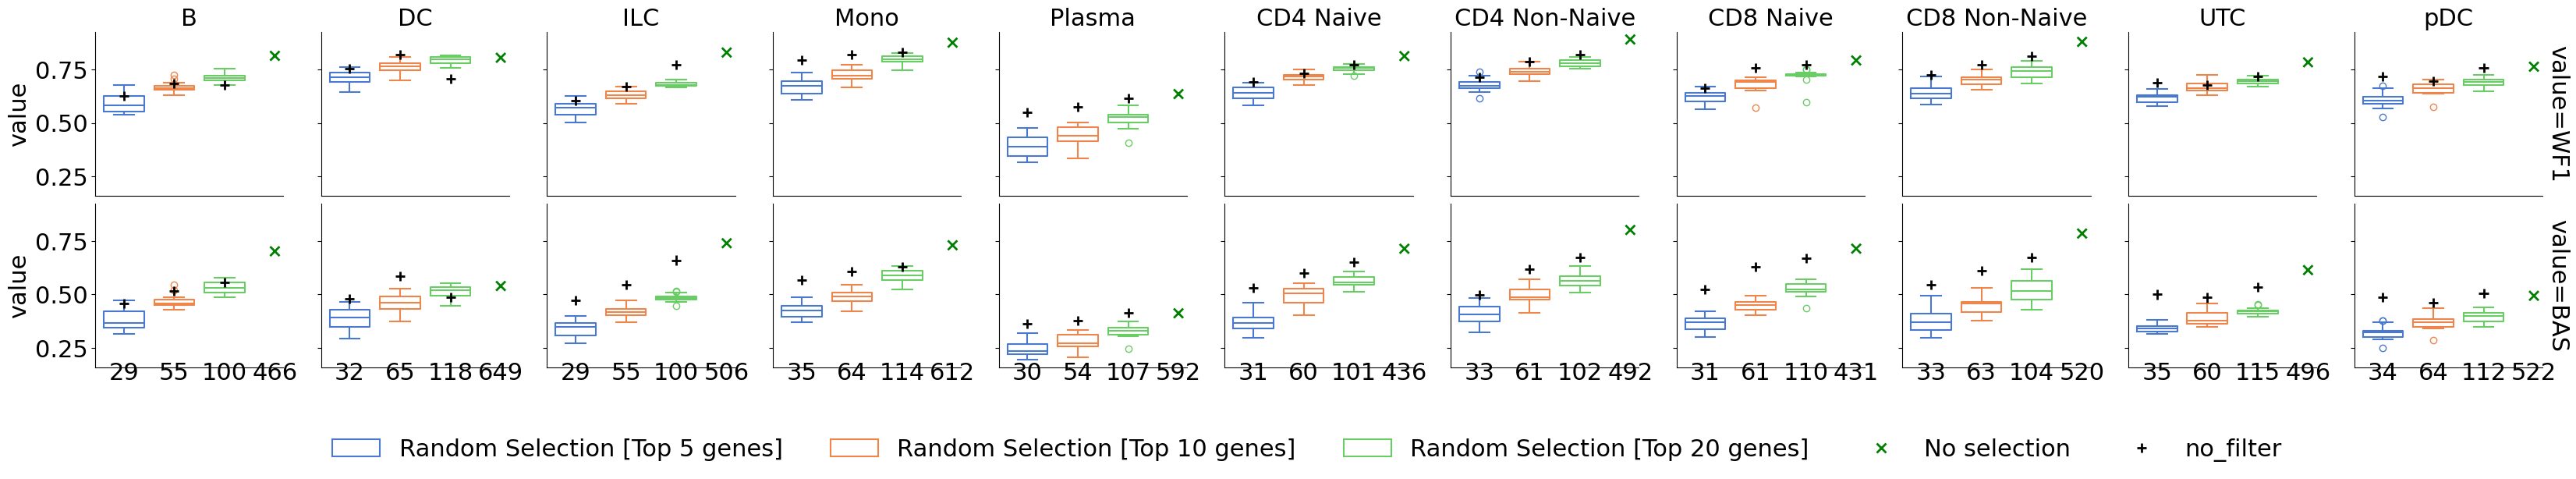

In [37]:
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = '22'

g = sns.FacetGrid(pdata.query("shap.isin(['No selection','no_filter', 'all']) or is_random"), col="cell_type", row="metric", height=3, aspect=1.1, margin_titles=True)

def barplot(data, x, y, hue, **kwargs):
    data = data.query("is_random")
    ax = sns.boxplot(x=x, y=y, hue=hue, data=data, legend=True, palette='muted', fill=False)
    current_celltype = data.cell_type.iloc[0]
    if data.metric.iloc[0] == 'BAS':
        for index, row in n_genes_df.query('cell_type == @current_celltype').iterrows():
            ax.text(row[x], 0.1, row['n_genes'], color='black', ha="center",size=22)
g.map_dataframe(barplot, x='selection', y='value', hue='shap')

def scatterplot(data, x, y, hue, **kwargs):
    data = data.query("not is_random").assign(nos=lambda df: ["No Selection" if x == "No selection" else "Shap Selection" for x in df.selection])
    ax = sns.scatterplot(x=x, y=y, hue='shap', style='shap',
                         palette=["green", "black"], 
                         markers=["x","+"], 
                         linewidth=2, s=75, data=data, legend=True, zorder=100)
g.map_dataframe(scatterplot, x='selection', y='value', hue='shap')

g.set_titles(col_template='{col_name}',row_template='value={row_name}')
g.set(xticks=[],xlabel=None)
g.figure.subplots_adjust(wspace=.2, hspace=0.05)
g.add_legend(bbox_to_anchor=(0.5, 0), ncols=5)

plt.savefig("figures/performance_shap_selection.svg", dpi=600, bbox_inches='tight')